In [2]:
import random
import gym 
import numpy as np
from collections import deque, namedtuple
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Flatten, Conv2D, MaxPooling2D, Input
from tensorflow.keras.optimizers import Adam





In [3]:
# Defining the DQN class
# Basic vanilla implimentation eventually worked very well, but struggled with double dqn.
class DQN:
    def __init__(self, state_size, action_size, buffer_size=20000, gamma=0.95, update_rate=1000):
        # Define the state size
        self.state_size = state_size
        # Define the action size
        self.action_size = action_size
        # Define the replay buffer
        self.buffer_size = buffer_size
        self.replay_buffer = deque(maxlen=buffer_size)
        self.data_buffer = deque(maxlen=buffer_size)
        # Define the discount factor
        self.gamma = gamma
        # Define the target network update rate (for hard updates only)
        self.update_rate = update_rate
        # Define the agent and target networks
        self.main_network = self.build_network()
        self.target_network = self.build_network()
        # Copy the weights from the main network to the target network
        self.target_network.set_weights(self.main_network.get_weights())
       
        
    def build_network(self, net_arc=[512]):
        model = Sequential()
        model.add(Dense(net_arc[0], activation='elu', input_shape = self.state_size))
        for i in range(len(net_arc)-1):
            model.add(Dense(net_arc[i+1], activation='elu'))
        model.add(Dense(self.action_size, activation='linear'))
        # Have not yet compiled the model for lack of a loss function (want to implement this using gradient
        # tape for practice)
        return model
        
        
    def store_transitions(self, state, action, reward, next_state, done):
        if len(self.replay_buffer) < self.buffer_size:
            self.replay_buffer.append((state, action, reward, next_state, done))
        else:
            self.replay_buffer.popleft()
            self.replay_buffer.append((state, action, reward, next_state, done))

    def epsilon_greedy(self, state, epsilon):
        if random.uniform(0,1) < epsilon:
            action = np.random.randint(0,2)
        else:
            Q_values = self.main_network(tf.convert_to_tensor(state[np.newaxis]))
            action = np.argmax(Q_values.numpy()[0], axis=0)
        return action
    
    def sample_experiences(self, batch_size):
        """
        Returns 5 np.array() objects containing batch_size elements corresponding to the minibatch for 
        each element recorded in the replay buffer
        """
        indices = np.random.randint(len(self.replay_buffer), size=batch_size)
        batch = [self.replay_buffer[index] for index in indices]
        states, actions, rewards, next_states, dones = [
            np.array([experience[field_index] for experience in batch]) for field_index in range(5)
        ]
        return states, actions, rewards, next_states, dones
    
    def epsilon_scheduler(self, episode, total_episodes, init_eps=1, pure_exp_frac=0.1, final_eps=0.1):
        grad = (final_eps - init_eps)/((1 - (pure_exp_frac + 0.5))*total_episodes)
        if episode<pure_exp_frac*total_episodes:
            epsilon = init_eps
        else:
            epsilon = max(init_eps + grad*(episode - pure_exp_frac*total_episodes), final_eps)
            
        return epsilon  
    
    def train(self, batch_size, optimizer=tf.keras.optimizers.Adam(lr=0.001)):
        # Compute the target value using the target network
        states, actions, rewards, next_states, dones = self.sample_experiences(batch_size)
#         main_out = self.main_network.predict(next_states)
#         next_optim_action = np.argmax(main_out, axis=1)
#         mask = tf.one_hot(next_optim_action, self.action_size)
        next_Q_values = self.target_network.predict(next_states)
        max_next_Q_values = np.max(next_Q_values, axis=1)
        target_Q = (rewards + (1 - dones) * self.gamma * max_next_Q_values)
        # Compute predicted Q values using the main network        
        mask = tf.one_hot(actions, self.action_size)
        with tf.GradientTape() as tape:
            all_Q_values = self.main_network(states)
            Q_values = tf.reduce_sum(all_Q_values * mask, axis=1)
            mse = tf.keras.losses.mean_squared_error(target_Q, Q_values)
            loss = tf.reduce_mean(mse)
        grads = tape.gradient(loss, self.main_network.trainable_variables)
        optimizer.apply_gradients(zip(grads, self.main_network.trainable_variables))
                        
                        
    def update_target_network(self):
        self.target_network.set_weights(self.main_network.get_weights())

        



In [4]:
env = gym.make('CartPole-v1')
state_size = env.observation_space.shape
action_size = env.action_space.n

def preprocess(state):
    x = state/np.array([4.8, 3, 0.418, 3])
    return x

num_episodes = 600
num_timesteps = 200
batch_size = 8
dqn = DQN(state_size, action_size)
done = False
time_step = 0
reward_benchmark = 0
return_array = np.zeros(num_episodes)
state_array = np.zeros((4,num_episodes*num_timesteps))
for i in range(num_episodes):
    state = env.reset()
    epsilon = dqn.epsilon_scheduler(i, num_episodes, pure_exp_frac=0.1, final_eps=0.01)
    actions = []
    for t in range(num_timesteps):
        #env.render()
        time_step+=1
#         if time_step % dqn.update_rate ==0:
#             dqn.update_target_network()
#             print(epsilon)
        prep_state = preprocess(state)
        action = dqn.epsilon_greedy(state, epsilon)
        actions.append(action)
        next_state, reward, done, _ = env.step(action)
        dqn.store_transitions(state, action, reward, next_state, done)
        state = next_state
        return_array[i]+=reward
        if t==num_timesteps:
            done=True
            
            
        if done:
            print('episode: ',i, ', ','Return: ', return_array[i])
            break  
        else:
            pass
        if i > 5:
            dqn.train(batch_size)
    if return_array[i]>reward_benchmark:
        reward_benchmark=return_array[i]
        best_model = dqn.main_network
        

episode:  0 ,  Return:  13.0
episode:  1 ,  Return:  11.0
episode:  2 ,  Return:  19.0
episode:  3 ,  Return:  16.0
episode:  4 ,  Return:  12.0
episode:  5 ,  Return:  24.0

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

episode:  6 ,  Return:  49.0
episode:  7 ,  Return:  14.0
episode:  8 ,  Return:  13.0
episode:  9 ,  Return:  27.0
episode:  10 ,  Return:  15.0
episode:  11 ,  Return:  24.0
episode:  12 ,  Return:  27.0
episode:  13 ,  Return:  18.0
episode:  14 ,  Return:  14.0
episode:  15 ,  Return:  17.0
episode:  16 ,  Return:  14.0
episode:

episode:  246 ,  Return:  12.0
episode:  247 ,  Return:  9.0
episode:  248 ,  Return:  13.0
episode:  249 ,  Return:  11.0
episode:  250 ,  Return:  8.0
episode:  251 ,  Return:  8.0
episode:  252 ,  Return:  11.0
episode:  253 ,  Return:  9.0
episode:  254 ,  Return:  9.0
episode:  255 ,  Return:  10.0
episode:  256 ,  Return:  14.0
episode:  257 ,  Return:  13.0
episode:  258 ,  Return:  12.0
episode:  259 ,  Return:  8.0
episode:  260 ,  Return:  9.0
episode:  261 ,  Return:  10.0
episode:  262 ,  Return:  8.0
episode:  263 ,  Return:  10.0
episode:  264 ,  Return:  9.0
episode:  265 ,  Return:  10.0
episode:  266 ,  Return:  11.0
episode:  267 ,  Return:  10.0
episode:  268 ,  Return:  10.0
episode:  269 ,  Return:  9.0
episode:  270 ,  Return:  9.0
episode:  271 ,  Return:  12.0
episode:  272 ,  Return:  10.0
episode:  273 ,  Return:  13.0
episode:  274 ,  Return:  8.0
episode:  275 ,  Return:  10.0
episode:  276 ,  Return:  9.0
episode:  277 ,  Return:  11.0
episode:  278 ,  Retu

episode:  515 ,  Return:  10.0
episode:  516 ,  Return:  9.0
episode:  517 ,  Return:  9.0
episode:  518 ,  Return:  10.0
episode:  519 ,  Return:  9.0
episode:  520 ,  Return:  10.0
episode:  521 ,  Return:  8.0
episode:  522 ,  Return:  10.0
episode:  523 ,  Return:  10.0
episode:  524 ,  Return:  10.0
episode:  525 ,  Return:  11.0
episode:  526 ,  Return:  10.0
episode:  527 ,  Return:  9.0
episode:  528 ,  Return:  9.0
episode:  529 ,  Return:  8.0
episode:  530 ,  Return:  12.0
episode:  531 ,  Return:  10.0
episode:  532 ,  Return:  11.0
episode:  533 ,  Return:  9.0
episode:  534 ,  Return:  11.0
episode:  535 ,  Return:  10.0
episode:  536 ,  Return:  10.0
episode:  537 ,  Return:  10.0
episode:  538 ,  Return:  9.0
episode:  539 ,  Return:  11.0
episode:  540 ,  Return:  10.0
episode:  541 ,  Return:  9.0
episode:  542 ,  Return:  8.0
episode:  543 ,  Return:  9.0
episode:  544 ,  Return:  10.0
episode:  545 ,  Return:  10.0
episode:  546 ,  Return:  10.0
episode:  547 ,  Ret

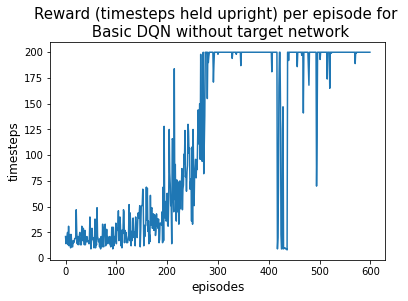

In [10]:
plt.plot(return_array)
plt.title("Reward (timesteps held upright) per episode for \n Basic DQN without target network", fontsize=15)
plt.ylabel("timesteps", fontsize=12)
plt.xlabel("episodes", fontsize=12)
#plt.savefig("SimpleDQNlearning1", dpi=400)

In [5]:
best_model.save('Best_DDQN')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: Best_DDQN/assets


In [6]:
state[np.newaxis]

array([[-0.21803465, -0.37217626, -0.01588192,  0.18843444]])

In [7]:
dqn.main_network.save('final_DDQN')

INFO:tensorflow:Assets written to: final_DDQN/assets
